# 02_07 물류 네트워크 최적 설계를 위한 테크닉 10

#### 고객의 소리:
운송 비용을 조정 하는 것 만으로도 최적화 가능성이 보였다.  
이왕이면 제조에서 물류까지의 전체 흐름 중 어디에 비용 개선 가능성이 있는지 분석을 원한다.


#### 전제조건:  
1. 최종적으로 제품을 판매하는 대리점(P,Q)가 있다.
2. 판매되는 상품군(제품 A,B)에는 일정 수요가 예측되어 있다.
3. 이 수요량을 근거로 공장(공장 X,Y)에서의 생산량을 결정한다.
4. 어느 공장의 어느 생산라인(레인 0,1)에서 제조할지 각 공장에서 대리점으로까지의 운송비, 제고 비용 등을 고려해서 결정한다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### 테크닉061: 운송 최적화 문제를 풀어보자

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# 데이터 불러오기
df_tc = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/trans_cost.csv', index_col="공장")
df_demand = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/demand.csv')
df_supply = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/supply.csv')

# 초기 설정
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))

# 수리 모델 작성
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)
for i in range(nw):
    m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]
for j in range(nf):
    m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]
m1.solve()

# 총 운송 비용 계산
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x)
    total_cost += df_tc.iloc[i][j]*value(x)
    
print(df_tr_sol)
print("총 운송 비용:"+str(total_cost))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/adam/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7r/wgftjkfx18j59k9jdyw6892c0000gn/T/c4f600921c4448e0b948943b9e584f1c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/7r/wgftjkfx18j59k9jdyw6892c0000gn/T/c4f600921c4448e0b948943b9e584f1c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 49 RHS
At line 57 BOUNDS
At line 58 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 7 (0) rows, 12 (0) columns and 24 (0) elements
0  Obj 0 Primal inf 113 (4)
7  Obj 1296
Optimal - objective value 1296
Optimal objective 1296 - 7 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.01

    F1  F2  F3  F4
공

처음에 terminal에서 '!conda install pulp'로 설치 하고 pulp 라이브러리를 실행 했을 때 충돌이 일어나서 오류 메세지가 발생했다.  
해결 방법은 터미널에서 pip uninstall pulp로 라이브러리를 삭제하고,  
'!pip install pulp'로 설치해서 위의 코드를 실행하면 충돌 문제가 해결된다.

### 테크닉062: 최적 운송 경로를 네트워크로 확인하자

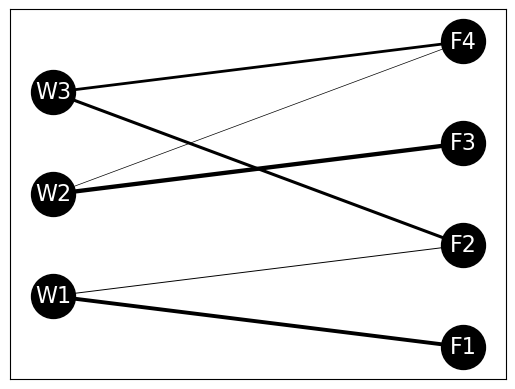

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# 데이터 불러오기
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/trans_route_pos.csv')

# 객체 생성
G = nx.Graph()

# 노드 설정
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
# 엣지 설정 및 엣지의 가중치 리스트화
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
    for j in range(len(df_pos.columns)):
        if not (i==j):
            # 엣지 추가
            G.add_edge(df_pos.columns[i],df_pos.columns[j])
            # 엣지 가중치 추가
            if num_pre<len(G.edges):
                num_pre = len(G.edges)
                weight = 0
                if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
                    if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
                        weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
                elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
                    if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
                        weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
                edge_weights.append(weight)

# 좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
    
# 그리기
nx.draw_networkx(G, pos, with_labels=True,font_size=16, node_size= 1000, node_color='k', font_color='w', width=edge_weights)

# 표시
plt.show()

### 테크닉063: 최적 운송 경로가 제약 조건을 만족하는지 확인하자

In [4]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_demand = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/demand.csv')
df_supply = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/supply.csv')

# 제약 조건 계산 함수
# 수요측
def condition_demand(df_tr,df_demand):
    flag = np.zeros(len(df_demand.columns))
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if (temp_sum>=df_demand.iloc[0][i]):
            flag[i] = 1
    return flag

# 공급측
def condition_supply(df_tr,df_supply):
    flag = np.zeros(len(df_supply.columns))
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum<=df_supply.iloc[0][i]:
            flag[i] = 1
    return flag

print("수요 조건 계산 결과:"+str(condition_demand(df_tr_sol,df_demand)))
print("공급 조건 계산 결과:"+str(condition_supply(df_tr_sol,df_supply)))

수요 조건 계산 결과:[1. 1. 1. 1.]
공급 조건 계산 결과:[1. 1. 1.]


### 테크닉064: 생산 계획 데이터를 불러오자 

#### 데이터 정보
|No.|파일 이름|개요|
|-|-|-|
|1|product_plan_material.csv|제품 제조에 필요한 원료 비율|
|2|product_plan_profit.csv|제품 이익|
|3|product_plan_stock.csv|원료 재고|
|4|product_plan.csv|제품 생산량|

In [5]:
import pandas as pd

df_material = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/product_plan_material.csv', index_col="제품")
print(df_material)
df_profit = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/product_plan_profit.csv', index_col="제품")
print(df_profit)
df_stock = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('/Users/adam/Data_Analytics/Python/Field/07/product_plan.csv', index_col="제품")
print(df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


### 테크닉065: 이익을 계산하는 함수를 만들자

In [6]:
def product_plan(df_profit,df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        for j in range(len(df_plan.columns)):
            profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
        return profit

print("총 이익:"+str(product_plan(df_profit,df_plan)))

총 이익:80.0


In [7]:
### 테크닉066: 생산 최적화 문제를 풀어보자
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i),lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
    m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
    df_plan_sol.iloc[k] = value(x)
print(df_plan_sol)
print("총 이익:"+str(value(m.objective)))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/adam/anaconda3/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/7r/wgftjkfx18j59k9jdyw6892c0000gn/T/a5db770bc888453a923c9aca22d7e38d-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/7r/wgftjkfx18j59k9jdyw6892c0000gn/T/a5db770bc888453a923c9aca22d7e38d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 17 RHS
At line 21 BOUNDS
At line 22 ENDATA
Problem MODEL has 3 rows, 2 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 2 (0) columns and 6 (0) elements
0  Obj -0 Dual inf 8.9999998 (2)
0  Obj -0 Dual inf 8.9999998 (2)
2  Obj 95
Optimal - objective value 95
Optimal objective 95 - 2 iterations time 0.002
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):  

### 테크닉067: 최적 생산 계획이 제약 조건을 만족하는지 확인하자

In [8]:
def condition_stock(df_plan,df_material,df_stock):
    flag = np.zeros(len(df_material.columns))
    for i in range(len(df_material.columns)):
        temp_sum = 0
        for j in range(len(df_material.index)):
            temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
        if (temp_sum<=float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i]+" 사용량:"+str(temp_sum)+", 재고:"+str(float(df_stock.iloc[0][i])))
    return flag

print("제약 조건 계산 결과:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

원료1 사용량:25.0, 재고:40.0
원료2 사용량:80.0, 재고:80.0
원료3 사용량:50.0, 재고:50.0
제약 조건 계산 결과:[1. 1. 1.]


### 테크닉068: 물류네트워크 설계문제를 풀어보자

In [11]:
import numpy as np
import pandas as pd

제품 = list('AB')
대리점 = list('PQ')
공장 = list('XY')
레인 = (2,2)

# 운송비 #
tbdi = pd.DataFrame(((j,k) for j in 대리점 for k in 공장), columns=['대리점','공장'])
tbdi['운송비'] = [1,2,3,1]
print(tbdi)

# 수요 #
tbde = pd.DataFrame(((j,i) for j in 대리점 for i in 제품), columns=['대리점','제품'])
tbde['수요'] = [10,10,20,20]
print(tbde)

# 생산 #
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (공장,레인) for l in range(nl) for i in 제품), 
                    columns=['공장','레인','제품','하한','상한'])
tbfa['생산비'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'상한']=10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa,dep = "대리점", dem = "수요",fac = "공장",
                                prd = "제품",tcs = "운송비",pcs = "생산비",lwb = "하한",upb = "상한")

print(tbfa)
print(tbdi2)

  대리점 공장  운송비
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  대리점 제품  수요
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  공장  레인 제품  하한    상한  생산비
0  X   0  A   0   inf  1.0
3  X   1  B   0   inf  1.0
4  Y   0  A   0  10.0  3.0
6  Y   1  A   0   inf  5.0
7  Y   1  B   0   inf  3.0
  공장  레인 제품  하한    상한  생산비     VarY  ValY
0  X   0  A   0   inf  1.0  v000022  20.0
3  X   1  B   0   inf  1.0  v000023  10.0
4  Y   0  A   0  10.0  3.0  v000024  10.0
6  Y   1  A   0   inf  5.0  v000025   0.0
7  Y   1  B   0   inf  3.0  v000026  20.0
  대리점 공장  운송비 제품     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0


### 테크닉069: 최적 네트워크의 운송 비용과 그 내역을 계산하자

In [13]:
tbdi2 = tbdi2[["공장","대리점","운송비","제품","VarX","ValX"]]
tbdi2

,공장,대리점,운송비,제품,VarX,ValX
0,X,P,1,A,v000014,10.0
1,X,P,1,B,v000015,10.0
2,X,Q,3,A,v000016,10.0
3,X,Q,3,B,v000017,0.0
4,Y,P,2,A,v000018,0.0
5,Y,P,2,B,v000019,0.0
6,Y,Q,1,A,v000020,10.0
7,Y,Q,1,B,v000021,20.0


In [15]:
trans_cost = 0
for i in range(len(tbdi2.index)):
    trans_cost += tbdi2["운송비"].iloc[i]*tbdi2["ValX"].iloc[i]
print("총 운송비:"+str(trans_cost))

총 운송비:80.0


### 테크닉070: 최적 네트워크의 생산 비용과 그 내역을 계산하자

In [16]:
tbfa

,공장,레인,제품,하한,상한,생산비,VarY,ValY
0,X,0,A,0,inf,1.0,v000022,20.0
3,X,1,B,0,inf,1.0,v000023,10.0
4,Y,0,A,0,10.0,3.0,v000024,10.0
6,Y,1,A,0,inf,5.0,v000025,0.0
7,Y,1,B,0,inf,3.0,v000026,20.0


In [17]:
product_cost = 0
for i in range(len(tbfa.index)):
    product_cost += tbfa["생산비"].iloc[i]*tbfa["ValY"].iloc[i]
print("총 생산비:"+str(product_cost))

총 생산비:120.0


중요한 것은 최적화 계산 라이브러리의 결과를 맹신하지 않고 항상 의심하는 자세를 가지며 현장의 업무 개선에 임하는 것이다.